**OVERVIEW**

**This notebook contains hyper parameter training, fitting and evaluation of OneHot-Encoded data with predictive modelling techniques.**

**The models are evaluated with several metrics, mainly F1 Score, AUC score visualised with the ROC curve and the calibration plot**
- F1 Score is chosen as it is a balance between precision and recall
- In the calibration plot, the x-axis represents the average predicted probability in each bin. The y-axis is the ratio of positives (the proportion of positive predictions). The curve of the ideal calibrated model is a linear straight line from (0, 0) moving linearly. 

**1) Random Forest - Hyperparameter Tuning with GridSearchCV**
- Accuracy - 0.67
- F1 Score: 0.70
- AUC: 0.74
- The calibration plot is better with hyperparameter tuning than it was while fitting RandomForest without tuning

**2) Gradient Boosting Classifier with RandomizedSearchCV**
- Accuracy - 0.68
- F1 Score: 0.70
- AUC: 0.73
- The calibration plot turns out to be more accurate and better than RandomForest with hyperparameter tuning.

**3) SVC with GridSearchCV**
- Accuracy - 0.97
- F1 Score: 0.97
- The Support Vector Classifier outperformed Random Forest and Gradient Boosting Classifiers by producing a classification accuracy and F1-Score of 0.97.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Loading ONE-HOT ENCODED DATASET from the DATA PREPARATION STEP
df5 = pd.read_csv("../data/pre-processed_data/df5.csv")
df5

,tmsp,amount,success,3D_secured,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,...,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2019-01-01 00:01:11,89,0,0,3,1.0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
1,2019-01-01 00:01:17,89,1,0,3,1.0,2,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,2019-01-01 00:02:49,238,0,1,3,1.0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
3,2019-01-01 00:03:13,238,1,1,3,1.0,2,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,2019-01-01 00:04:33,124,0,0,1,0.5,1,1,1,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50324,2019-02-28 23:45:39,415,0,0,3,1.0,1,2,28,23,...,0,1,0,1,0,0,0,1,0,0
50325,2019-02-28 23:46:48,91,0,0,3,1.0,1,2,28,23,...,0,1,1,0,0,0,0,1,0,0
50326,2019-02-28 23:47:04,91,0,0,3,1.0,2,2,28,23,...,0,1,1,0,0,0,0,1,0,0
50327,2019-02-28 23:47:36,91,0,0,3,1.0,3,2,28,23,...,0,1,1,0,0,0,0,1,0,0


In [3]:
features = df5.drop(["tmsp","success",'Month'],axis=1)
target = df5['success']

In [4]:
from imblearn.over_sampling import RandomOverSampler

# RANDOM OVER SAMPLER to handle class imbalance
ros = RandomOverSampler(sampling_strategy="not majority", random_state=7)
X_res, y_res = ros.fit_resample(features, target)

In [5]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [6]:
# EVALUATING METRICS AND PLOTTING 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report 

def metrics_and_plots(model, y_test, y_pred):
     # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.2f}")

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.2f}\n")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",conf_matrix,"\n")
    
    #Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Predict probabilities for positive class (success) for the test set
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, probs)
    print(f"\nAUC Score: {auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random Guess Line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Create Calibration Plot
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.figure(figsize=(6, 4))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Plot')
    plt.plot([0, 1], [0, 1], 'k--')  # Perfectly Calibrated Line
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Plot')
    plt.legend()
    plt.show()

 **Random Forest - Hyperparameter Tuning with GridSearch CV**

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=1, n_estimators=10; total time=   0.1s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   3.7s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   3.9s
[CV] END ......criterion=gini, max_depth=1, n_estimators=257; total time=   3.7s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   8.1s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   8.8s
[CV] END ......criterion=gini, max_depth=1, n_estimators=505; total time=   7.6s
[CV] END ......criterion=gini, max_depth=1, n_estimators=752; total time=  12.1s
[CV] END ......criterion=gini, max_depth=1, n_estimators=752; total time=  12.9s
[CV] END ......criterion=gini, max_depth=1, n_e

[CV] END ...criterion=entropy, max_depth=3, n_estimators=752; total time=  15.5s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  19.9s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  20.1s
[CV] END ..criterion=entropy, max_depth=3, n_estimators=1000; total time=  20.6s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   7.1s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   7.0s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=257; total time=   7.0s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=505; total time=  13.6s
[CV] END ...criterion=entropy, max_depth=5, n_estimators=505; total time=  13.7s
[CV] END ...criterion=entrop

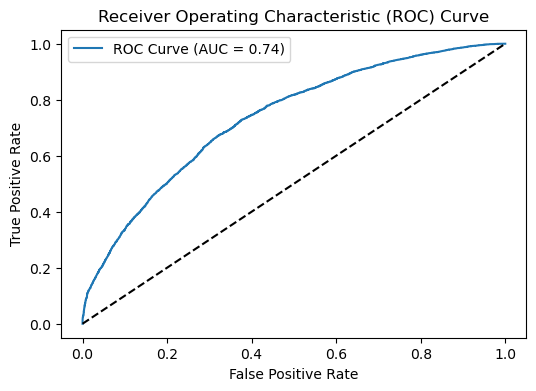

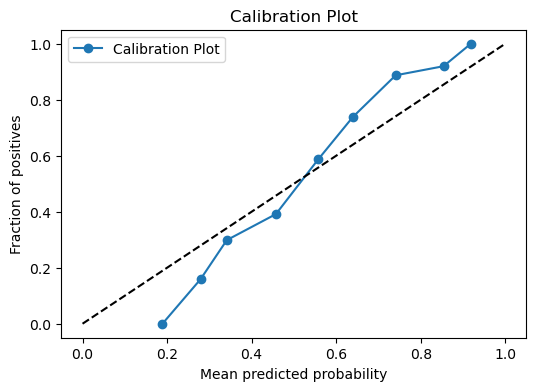

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
criterion = ['gini','entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 9, num = 5)]

rf_grid = {'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth}

rf = RandomForestClassifier(random_state=7)

rf_cv = GridSearchCV(rf,rf_grid,cv=3, verbose=2)

rf_cv.fit(X_res, y_res)

print(rf_cv.best_score_, rf_cv.best_params_)

# Predict on the test set with the best model
best_model = rf_cv.best_estimator_
rf_best_predictions = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, rf_best_predictions)
classification_report_result = classification_report(y_test, rf_best_predictions)
confusion_matrix_result = confusion_matrix(y_test, rf_best_predictions)

print("Random Forest Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)

metrics_and_plots(best_model,y_test,rf_best_predictions)

**Gradient Boosting Classifier with RandomizedSearch CV**

Best Parameters: {'learning_rate': 0.11495493205167782, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 157}
Accuracy: 0.68
Precision: 0.66
Recall: 0.74
F1 Score: 0.70

Confusion Matrix:
 [[4878 3090]
 [2117 5956]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.61      0.65      7968
           1       0.66      0.74      0.70      8073

    accuracy                           0.68     16041
   macro avg       0.68      0.67      0.67     16041
weighted avg       0.68      0.68      0.67     16041


AUC Score: 0.73


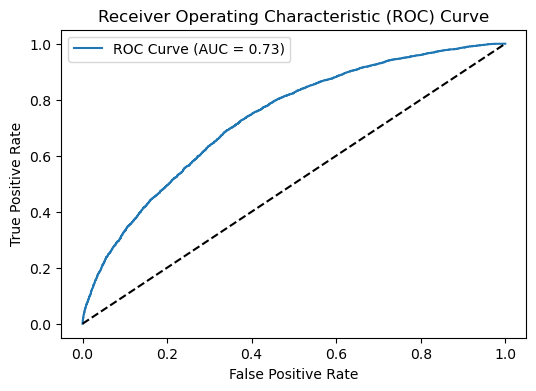

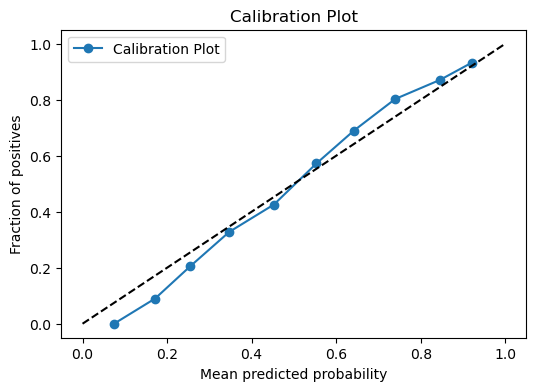

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# Create GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier()

# Define the parameter distributions to sample from
gb_param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 6),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create RandomizedSearchCV
gb_cv = RandomizedSearchCV(gb_classifier, param_distributions=gb_param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
gb_cv.fit(X_train, y_train)

# Get the best parameters
best_params = gb_cv.best_params_
print("Best Parameters:", best_params)

# Predict using the best model
gb_best_predictions = gb_cv.predict(X_test)

metrics_and_plots(gb_cv,y_test,gb_best_predictions)

**SVC - RandomSearchCV**

In [ ]:
from sklearn.svm import SVC 

SVC_model = SVC() 

# defining parameter range 
svc_param_dist = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['rbf']}  
  
svc_cv = GridSearchCV(SVC(), svc_param_dist, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svc_cv.fit(X_train, y_train) 
print(svc_cv.best_score_, svc_cv.best_params_)
# print best parameter after tuning 
print(svc_cv.best_params_) 
print(svc_cv.best_estimator_) 

svc_best_predictions = svc_cv.predict(X_test) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=22.0min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=22.8min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=24.6min


In [ ]:
# EVALUATION OF SVC CLASSIFIER
metrics_and_plots(svc_cv, y_test, svc_best_predictions)

In [ ]:
# Predict Probabilities
svc_prob = svc_cv.decision_function(X_test)
 
# Creating Calibration Curve
x, y = calibration_curve(y_test, svc_prob, n_bins = 10, normalize = True)
 
# Plot calibration curve
 
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'Support Vector Classifier')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()